# Study the cost of ensemble versus the performance

In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# modify this to set up directory:
DATA_DIR = "/home/data/wangz56"

model = "resnet56"
attack_list = ["losstraj", "reference", "lira", "calibration"]
# dataset_list = ["cifar10", "cifar100", "cinic10", "texas100", "purchase100"]
dataset_list = ["cifar10", "cifar100", "cinic10"]
ensemble_method_list = ["union", "intersection", "majority_vote"]
seeds = [0, 1, 2, 3, 4, 5]
path_to_data = f'{DATA_DIR}/miae_standard_exp'
path_to_save_result = f'{path_to_data}/ensemble_roc/{model}/cost_perf_analysis'
if os.path.exists(path_to_save_result) == False:
    os.makedirs(path_to_save_result)

ensemble_markers_mapping = {
    ('calibration', 'lira'): 'o',          # Circle
    ('calibration', 'losstraj'): 's',      # Square
    ('calibration', 'reference'): 'D',     # Diamond
    ('lira', 'losstraj'): '^',             # Triangle Up
    ('lira', 'reference'): 'v',            # Triangle Down
    ('losstraj', 'reference'): '<',        # Triangle Left
    ('calibration', 'lira', 'losstraj'): '>',    # Triangle Right
    ('calibration', 'lira', 'reference'): 'P',   # Plus (filled)
    ('calibration', 'losstraj', 'reference'): '*', # Star
    ('lira', 'losstraj', 'reference'): 'h',      # Hexagon1
    ('calibration', 'lira', 'losstraj', 'reference'): 'H'  # Hexagon2
}

def get_marker(row):
    attacks = []
    if row["losstraj"]:
        attacks.append("losstraj")
    if row["reference"]:
        attacks.append("reference")
    if row["lira"]:
        attacks.append("lira")
    if row["calibration"]:
        attacks.append("calibration")
    attacks = sorted(attacks)
    return ensemble_markers_mapping[tuple(attacks)]

Here, we define the runtime (cost) of each attack. Attacks are ran on with 2 L40s GPUs in parallel. The GPU's utilization is kept below 100% to avoid any performance degradation. The settings for shadow model and target model are all resnet56

breakdown of time for each attack:
- losstraj: 17 
- reference: 540 (for 20 shadow models) + 8 (for inference on each shadow model) = 548
- lira: 540 (for 20 shadow models) + 40 (for augmented queries inference on each shadow model) = 580
- calibration: 5

The cost of LIRA and reference are so high because they trains 20 shadow models on-line. Meaning that both samples of inference and sample for training are used. Whereas losstraj and calibration only use auxiliary data for preparing attack.



In [2]:

# cost of each attack in terms of time (minutes)
cost_table_time = {"losstraj": 17, 
              "reference": 548, 
              "lira": 580, 
              "calibration": 5,
              "lira_shadow_models": 540
              }

In [3]:
def load_ensemble_perf(dataset, num_seed, ensemble_method, path_to_data):
    path_to_df = f"{path_to_data}/ensemble_roc/{model}/{dataset}/{num_seed}_seeds/{ensemble_method}"
    df = pd.read_pickle(f"{path_to_df}/ensemble_perf.pkl")
    return df

Convert roc and acc of multiple dataset to a csv table.

In [4]:
from copy import deepcopy
perf_union_df = pd.DataFrame(columns=["losstraj", "reference", "lira", "calibration", "dataset", "AUC", "ACC", "cost", "num_instance", "TPR@0.001FPR"]
                               ).astype({"AUC": float, "ACC": float, "losstraj": bool, "reference": bool, "lira": bool, 
                                         "calibration": bool, "cost": int, "num_instance": int, "TPR@0.001FPR": float})
perf_intersection_df = deepcopy(perf_union_df)
perf_mv_df = deepcopy(perf_union_df)

for num_seed in range(2, len(seeds)+1):
    # merge to a single dataframe
    # rows: Ensemble Level, losstraj, reference, lira, calibration, dataset, ensemble_method, auc, acc
    for ensemble in ensemble_method_list:
        if ensemble == "majority_vote":
            perf_df = perf_mv_df
        elif ensemble == "union":
            perf_df = perf_union_df
        elif ensemble == "intersection":
            perf_df = perf_intersection_df

        for dataset in dataset_list:
            df = load_ensemble_perf(dataset, num_seed, ensemble, path_to_data)
            for _, row in df.iterrows():
                auc = row["AUC"]
                acc = row["ACC"]
                attack_names = row["Attack"].split("_")
                losstraj = "losstraj" in attack_names
                reference = "reference" in attack_names
                lira = "lira" in attack_names
                calibration = "calibration" in attack_names

                # filter attack_names
                attack_names = [attack for attack in attack_names if attack in attack_list]

                # calculate cost
                cost = sum([cost_table_time[attack] for attack in attack_names])
                # handle the case of both reference and lira are used
                if "reference" in attack_names and "lira" in attack_names:
                    cost -= cost_table_time["lira_shadow_models"]
                # account for number of seeds
                cost *= num_seed
                
                new_entry = {"losstraj": losstraj, 
                             "reference": reference, "lira": lira, "calibration": calibration, 
                             "dataset": dataset, "AUC": auc, "ACC": acc, "cost": cost, "num_instance": num_seed, "TPR@0.001FPR": row["TPR@0.001FPR"]}
                new_entry = pd.DataFrame([new_entry]).astype(perf_df.dtypes.to_dict())
                perf_df = pd.concat([perf_df, new_entry], ignore_index=True)

        if ensemble == "majority_vote":
            perf_mv_df = perf_df
        elif ensemble == "union":
            perf_union_df = perf_df
        elif ensemble == "intersection":
            perf_intersection_df = perf_df
            


Plot the cost of each attack versus the performance of each attack.

Plotting cifar10 union
Plotting cifar100 union
Plotting cinic10 union
Plotting cifar10 intersection
Plotting cifar100 intersection
Plotting cinic10 intersection
Plotting cifar10 majority_vote
Plotting cifar100 majority_vote
Plotting cinic10 majority_vote


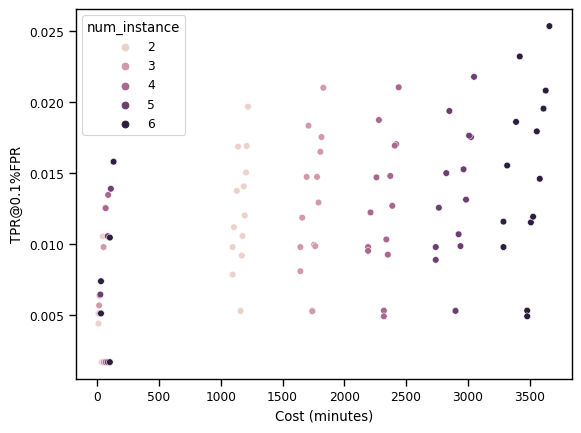

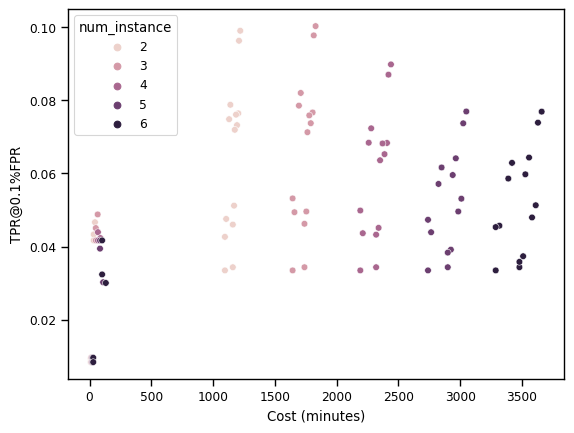

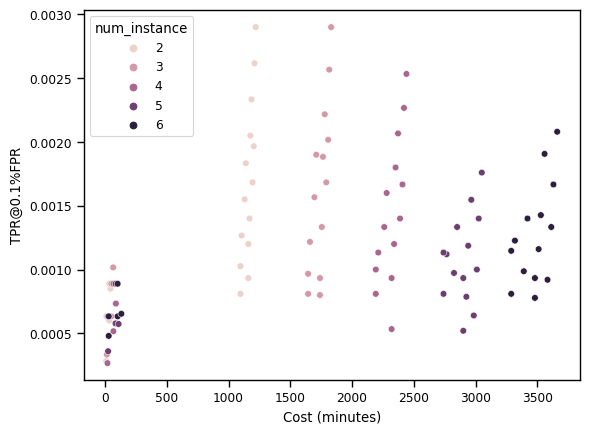

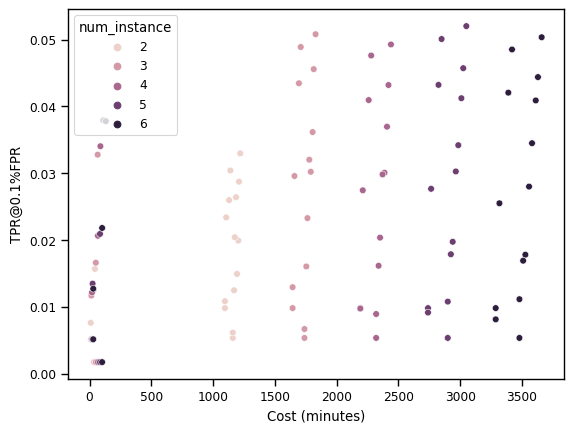

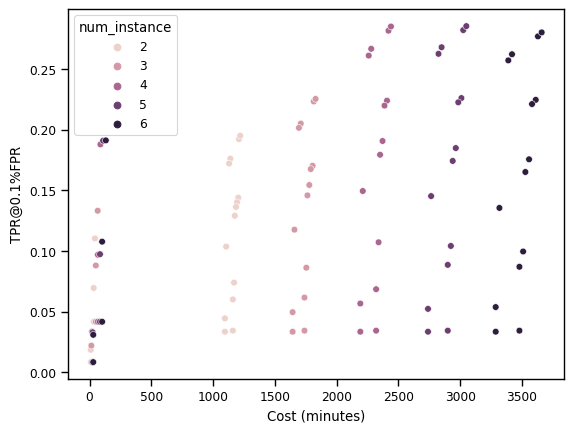

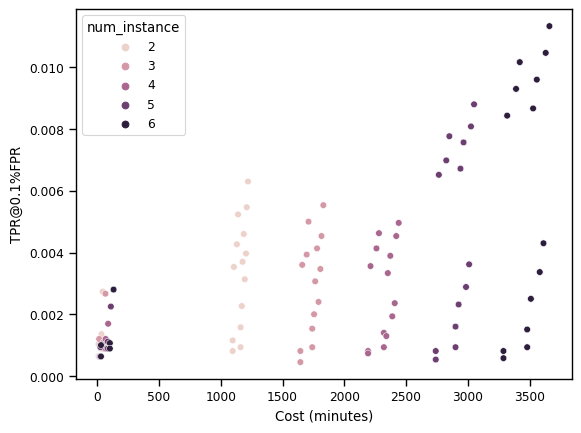

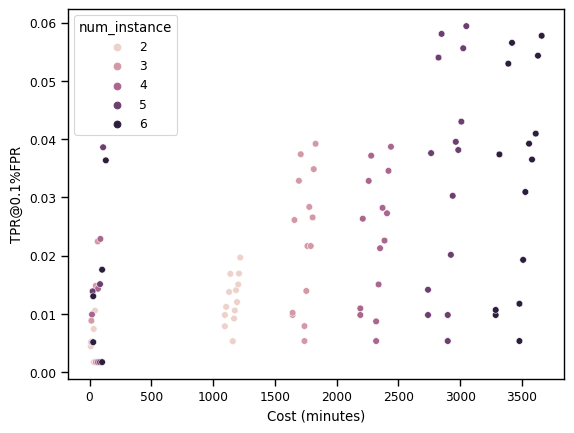

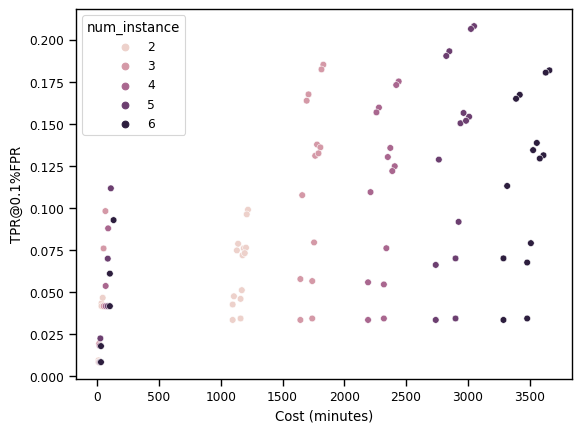

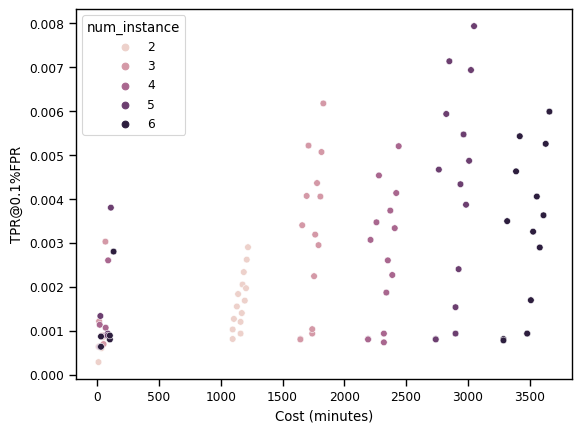

In [5]:
sns.set_context("paper")

if os.path.exists(path_to_save_result) == False:
    os.makedirs(path_to_save_result)


for ensemble in ensemble_method_list:
    if ensemble == "majority_vote":
        perf_df = perf_mv_df
    elif ensemble == "union":
        perf_df = perf_union_df
    elif ensemble == "intersection":
        perf_df = perf_intersection_df

    for dataset in dataset_list:
        print(f"Plotting {dataset} {ensemble}")
        df = perf_df[perf_df["dataset"] == dataset]

        # plot AUC vs cost
        plt.figure()
        sns.scatterplot(x="cost", y="TPR@0.001FPR", hue="num_instance", data=df)
        plt.xlabel("Cost (minutes)")
        plt.ylabel("TPR@0.1%FPR")

        plt.savefig(f"{path_to_save_result}/{dataset}_{ensemble}_cost_vs_perf.pdf",
                     bbox_inches='tight', format='pdf')
        